C:\Users\jvgat\AppData\Local\Temp\ipykernel_9752\1548017085.py:7: DtypeWarning: Columns (34,35,36,37,39,40,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")


Cross-listing count distribution:
count    127515.000000
mean          1.445155
std           0.497048
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: cross_listing_count, dtype: float64

CWE risk factor distribution:
count    127515.000000
mean          0.005289
std           0.009339
min           0.000000
25%           0.000576
50%           0.001830
75%           0.008772
max           1.000000
Name: cwe_risk_factor, dtype: float64

New strata distribution:
cross_listing_count_cat  cwe_risk_category
low                      low                  25843
                         medium               21011
                         high                 23901
medium                   low                  21075
                         medium               17629
                         high                 18052
high                     low                      1
                         high                     3
dt

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a


Model Summary:
                                 coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                    
base_score                   0.449385   1.567349  0.028724        0.393087   
repo_publication_lag_sqrt   -0.000010   0.999990  0.000002       -0.000015   
cross_listing_variance_sqrt -0.127499   0.880294  0.096730       -0.317086   

                             coef upper 95%  exp(coef) lower 95%  \
covariate                                                          
base_score                         0.505683             1.481548   
repo_publication_lag_sqrt         -0.000006             0.999985   
cross_listing_variance_sqrt        0.062088             0.728268   

                             exp(coef) upper 95%  cmp to          z  \
covariate                                                             
base_score                              1.658118     0.0  15.644962   
repo_publication_lag_sqrt              

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2744: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, _df in self._predicted_partial_hazards_.groupby(self.strata):



Concordance index: 0.6891080171192087


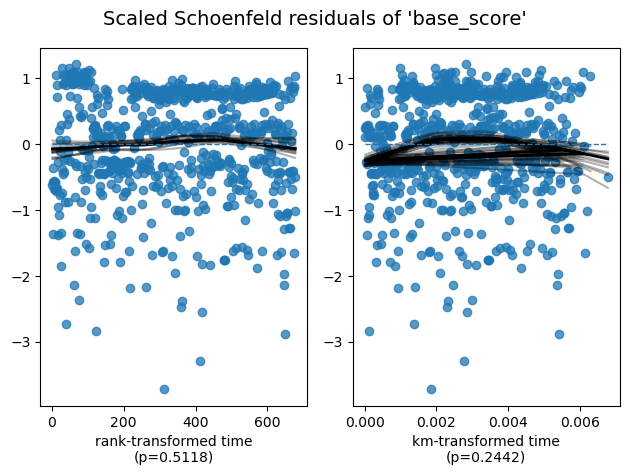

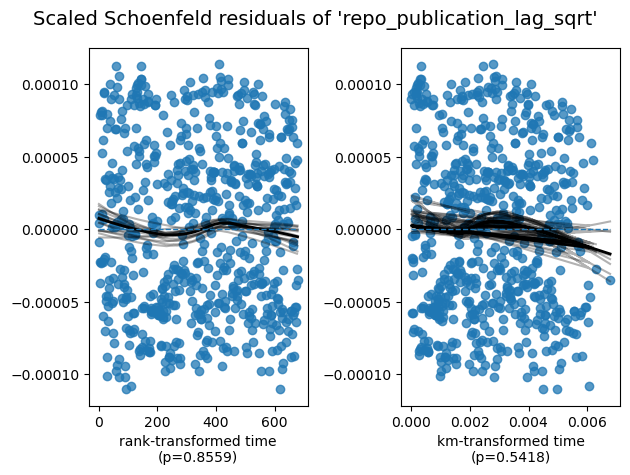

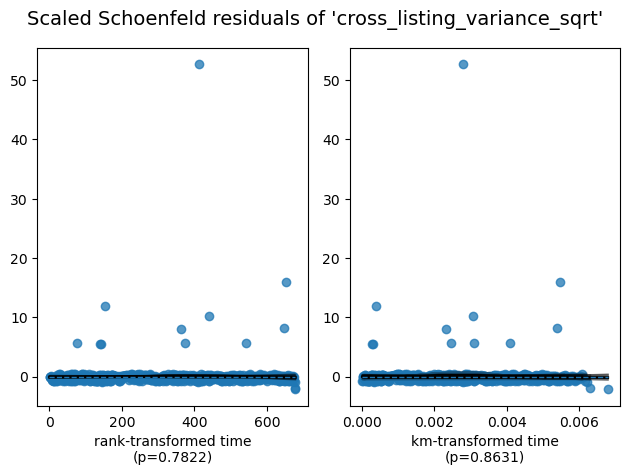

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")
date_cols = ['published_date','kev_published']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

df['time_to_event'] = (df['kev_published'] - df['published_date']).dt.total_seconds() / (60*60*24)
df['event'] = df['kev_present']
df.loc[df['event'] == 0, 'time_to_event'] = (pd.Timestamp.now(tz='UTC') - df.loc[df['event'] == 0, 'published_date']).dt.total_seconds() / (60*60*24)

features = ['base_score', 'repo_publication_lag', 'cross_listing_count','cross_listing_variance', 'cwe_risk_factor']
df_model = df[features + ['time_to_event', 'event']].dropna().copy()

# Apply transformations
df_model['repo_publication_lag_sqrt'] = df_model['repo_publication_lag'].rank()
df_model['cross_listing_variance_sqrt'] = np.sqrt(df_model['cross_listing_variance'])

# FIXED: Better categorization based on actual data distribution
print("Cross-listing count distribution:")
print(df_model['cross_listing_count'].describe())
print("\nCWE risk factor distribution:")
print(df_model['cwe_risk_factor'].describe())

# Create categories that actually have data
df_model['cross_listing_count_cat'] = pd.cut(
    df_model['cross_listing_count'], 
    bins=[0, 1, 2, float('inf')],  # Adjusted bins
    labels=['low', 'medium', 'high']
)

df_model['cwe_risk_category'] = pd.qcut(
    df_model['cwe_risk_factor'], 
    q=3,  # Reduced to 3 categories
    labels=['low', 'medium', 'high'],
    duplicates='drop'
)

# Verify the new distribution
print("\nNew strata distribution:")
strata_counts = df_model.groupby(['cross_listing_count_cat', 'cwe_risk_category'], observed=True).size()
print(strata_counts)
print(f"\nNumber of valid strata: {len(strata_counts[strata_counts > 0])}")

# Define transformed features and columns to include
transformed_features = ['base_score', 'repo_publication_lag_sqrt', 
                       'cross_listing_variance_sqrt']

model_cols = transformed_features + ['time_to_event', 'event', 
                                     'cross_listing_count_cat', 'cwe_risk_category']

df_final = df_model[model_cols].copy()

# Fit model with fixed stratification
cph = CoxPHFitter()
cph.fit(df_final, 
        duration_col='time_to_event', 
        event_col='event',
        strata=['cross_listing_count_cat', 'cwe_risk_category'])

print("\n" + "="*50)
print("Model Summary:")
print("="*50)
print(cph.summary)

# Check assumptions
cph.check_assumptions(df_final, 
                      columns=transformed_features, 
                      p_value_threshold=0.05, 
                      show_plots=True)

print(f"\nConcordance index: {cph.concordance_index_}")

In [2]:
df_final[df_final['event'] == 0].groupby(
    ['cross_listing_count_cat', 'cwe_risk_category']
).size()

C:\Users\jvgat\AppData\Local\Temp\ipykernel_9752\693183701.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final[df_final['event'] == 0].groupby(


cross_listing_count_cat  cwe_risk_category
low                      low                  25842
                         medium               21011
                         high                 23900
medium                   low                  21062
                         medium               17533
                         high                 17485
high                     low                      1
                         medium                   0
                         high                     3
dtype: int64

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

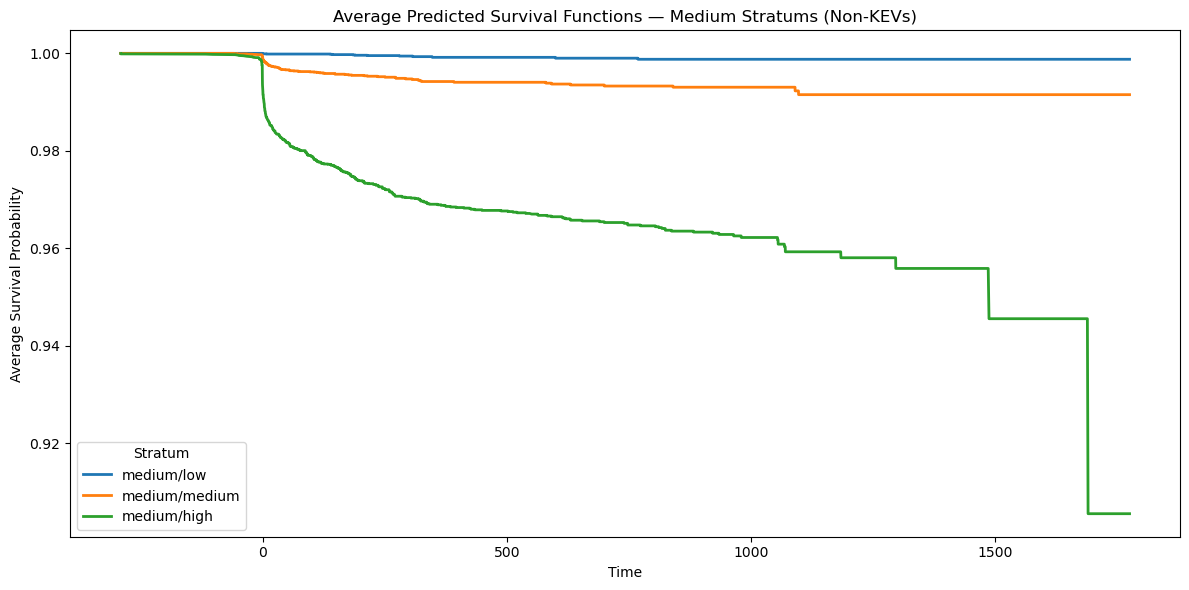

In [3]:
# ------------------------------
# 1) Keep only non-KEVs
# ------------------------------
df_nonkev = df_final[df_final['event'] == 0].copy()

# ------------------------------
# 2) Compute partial hazard for non-KEVs
# ------------------------------
df_nonkev['risk_score'] = cph.predict_partial_hazard(df_nonkev)

# ------------------------------
# 3) Merge metadata
# ------------------------------
df_nonkev = df_nonkev.merge(
    df[['vendorProject', 'product', 'vulnerabilityName']],
    left_index=True,
    right_index=True,
    how='left'
)

# ------------------------------
# 4) Create stratum column
# ------------------------------
df_nonkev['stratum'] = (
    df_nonkev['cross_listing_count_cat'].astype(str) + '/' +
    df_nonkev['cwe_risk_category'].astype(str)
)

# ------------------------------
# 5) Focus on selected strata
# ------------------------------
strata_focus = ['medium/low', 'medium/medium', 'medium/high']
df_focus = df_nonkev[df_nonkev['stratum'].isin(strata_focus)]

# ------------------------------
# 6) Average survival curves per stratum
# ------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    
    if df_stratum.empty:
        continue
    
    # Predict survival functions for all rows in this stratum
    surv_funcs = cph.predict_survival_function(df_stratum)
    
    # Compute average survival at each time point
    avg_surv = surv_funcs.mean(axis=1)
    
    ax.plot(avg_surv.index, avg_surv.values, label=stratum, linewidth=2)

ax.set_title("Average Predicted Survival Functions — Medium Stratums (Non-KEVs)")
ax.set_xlabel("Time")
ax.set_ylabel("Average Survival Probability")
ax.legend(title="Stratum")
plt.tight_layout()
plt.show()

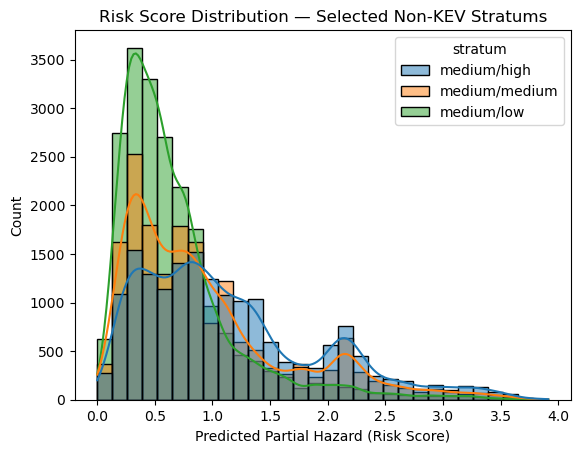

In [4]:
import seaborn as sns
sns.histplot(df_focus, x='risk_score', hue='stratum', kde=True, bins=30)
plt.title("Risk Score Distribution — Selected Non-KEV Stratums")
plt.xlabel("Predicted Partial Hazard (Risk Score)")
plt.ylabel("Count")
plt.show()

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

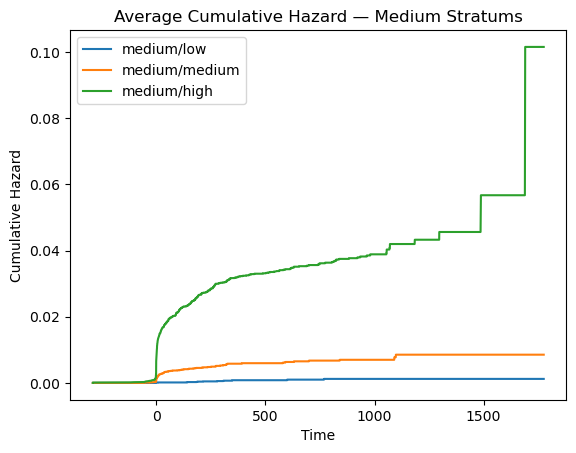

In [5]:
for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    cumhaz = cph.predict_cumulative_hazard(df_stratum).mean(axis=1)
    plt.plot(cumhaz.index, cumhaz.values, label=stratum)

plt.title("Average Cumulative Hazard — Medium Stratums")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.legend()
plt.show()


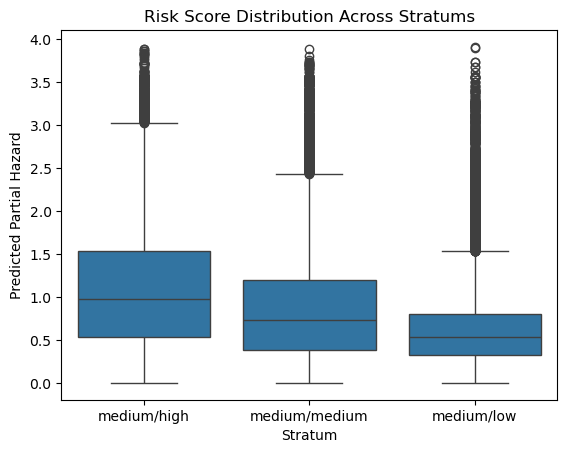

In [6]:
sns.boxplot(data=df_focus, x='stratum', y='risk_score')
plt.title("Risk Score Distribution Across Stratums")
plt.xlabel("Stratum")
plt.ylabel("Predicted Partial Hazard")
plt.show()